<font size="+3"><strong>2.5. Predicting Apartment Prices in Mexico City 🇲🇽</strong></font>

In this assignment, you'll decide which libraries you need to complete the tasks. You can import them in the cell below. 👇

In [131]:
import warnings
import plotly.express as px 


from glob import glob
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

**Task 2.5.1**

<div class="alert alert-block alert-info">
<b>Tip:</b> Don't try to satisfy all the criteria in the first version of your <code>wrangle</code> function. Instead, work iteratively. Start with the first criteria, test it out with one of the Mexico CSV files in the <code>data/</code> directory, and submit it to the grader for feedback. Then add the next criteria.</div>

In [75]:
def wrangle(filepath):
    
    df = pd.read_csv(filepath)
    mask_ba=df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt=df["property_type"]=="apartment"
    mask_price=df["price_aprox_usd"]<100000
    
    df=df[mask_ba & mask_apt & mask_price]
    low,high=df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area=df["surface_covered_in_m2"].between(low,high)
    df=df[mask_area]
    df[["lat","lon"]]=df["lat-lon"].str.split(",",expand=True).astype(float)
    df.drop(columns="lat-lon",inplace=True)
    df["borough"]=df["place_with_parent_names"].str.split("|",expand=True)[1]
    df.drop(columns="place_with_parent_names",inplace=True)
    df.drop(columns=["floor","price_usd_per_m2","rooms","expenses","surface_total_in_m2"],inplace=True)
    df.drop(columns=["properati_url","property_type","operation","price","currency","price_per_m2","price_aprox_local_currency"],inplace=True)

    return df 
    

In [90]:
# Use this cell to test your wrangle function on the file `mexico-city-real-estate-1.csv`
frame1=wrangle('data/mexico-city-real-estate-1.csv')
frame1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 11 to 4605
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        1101 non-null   float64
 1   surface_covered_in_m2  1101 non-null   float64
 2   lat                    1041 non-null   float64
 3   lon                    1041 non-null   float64
 4   borough                1101 non-null   object 
dtypes: float64(4), object(1)
memory usage: 51.6+ KB


**Task 2.5.2** 

In [143]:
files = sorted(glob("data/mexico-city-real-estate-*.csv"))

files = sorted(glob("data/mexico-city-real-estate-*.csv"))
df = pd.concat([wrangle(i) for i in files]).reset_index(drop=True)
print(df.info())
df.head()

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
d

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
1,82737.39,75.0,19.362690,-99.150565,Benito Juárez
3,72197.60,62.0,19.291345,-99.124312,Tlalpan
4,44277.72,85.0,19.354987,-99.061709,Iztapalapa
13,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
18,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


**Task 2.5.3**

## Explore

<div class="alert alert-info" role="alert">
  <strong>Slight Code Change</strong>

In the following task, you'll notice a small change in how plots are created compared to what you saw in the lessons.
While the lessons use the global matplotlib method like <code>plt.plot(...)</code>, in this task, you are expected to use the object-oriented (OOP) API instead.
This means creating your plots using <code>fig, ax = plt.subplots()</code> and then calling plotting methods on the <code>ax</code> object, such as <code>ax.plot(...)</code>, <code>ax.hist(...)</code>, or <code>ax.scatter(...)</code>.

If you're using pandas’ or seaborn’s built-in plotting methods (like <code>df.plot()</code> or <code>sns.lineplot()</code>), make sure to pass the <code>ax=ax</code> argument so that the plot is rendered on the correct axes.

This approach is considered best practice and will be used consistently across all graded tasks that involve matplotlib.
</div>


**Task 2.5.4**

Text(0.5, 1.0, 'Distribution of Apartment Prices')

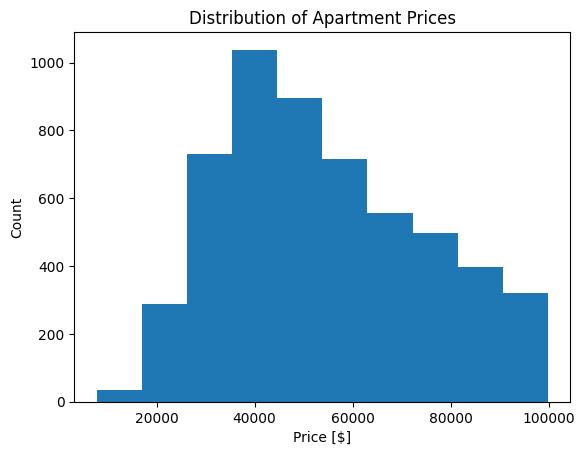

In [123]:
fig, ax = plt.subplots() 

# Plot the histogram on the axes object
ax.hist(x=df["price_aprox_usd"]) 

# Label axes using the axes 
ax.set_xlabel("Price [$]")
ax.set_ylabel("Count")


# Add title 
ax.set_title("Distribution of Apartment Prices")

**Task 2.5.5**

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

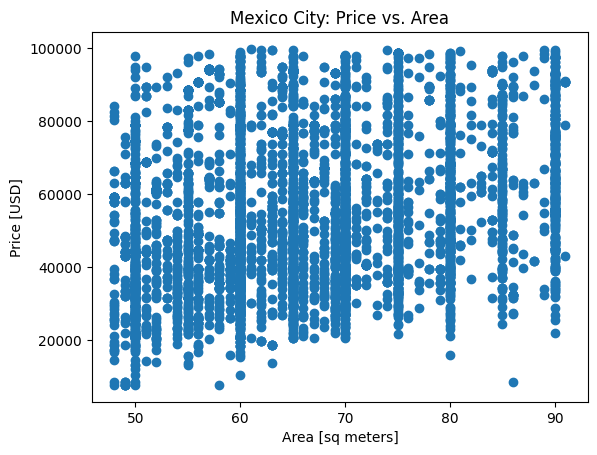

In [128]:
fig, ax = plt.subplots() 

# Create the scatter plot on the axes object
ax.scatter(x=df["surface_covered_in_m2"], y=df["price_aprox_usd"])


# Label axes 
ax.set_xlabel("Area [sq meters]")
ax.set_ylabel("Price [USD]")

#  Add title 
ax.set_title("Mexico City: Price vs. Area")

Do you see a relationship between price and area in the data? How is this similar to or different from the Buenos Aires dataset?<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

**Task 2.5.6** **(UNGRADED)** Create a Mapbox scatter plot that shows the location of the apartments in your dataset and represent their price using color. 

What areas of the city seem to have higher real estate prices?

In [ ]:
# Plot Mapbox location and price

fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=800,
    height=600,
    color="price_aprox_usd",
)


fig.show()

In [144]:
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


## Split

**Task 2.5.7**

In [150]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"

target = 'price_aprox_usd'
y_train = df[target]  # Target vector

X_train = df.drop(columns=[target])  # Feature matrix


y_train = df["price_aprox_usd"]
X_train = df.drop(columns=["price_aprox_usd"])
X_train.shape
y_train.shape

(5473, 4)

# Build Model

## Baseline

**Task 2.5.8**

In [154]:
y_mean =y_train.mean()
y_pred_baseline =[y_mean]*len(y_train)
baseline_mae =mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", round(y_mean,2))
print("Baseline MAE:", round(baseline_mae,2))

Mean apt price: 54246.53
Baseline MAE: 17239.94


## Iterate

**Task 2.5.9**

In [184]:
# Build Model
model=make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
    
)
# Fit model
model.fit(X_train,y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

**Task 2.5.10**

<div class="alert alert-block alert-info">
<b>Tip:</b> Make sure the <code>X_train</code> you used to train your model has the same column order as <code>X_test</code>. Otherwise, it may hurt your model's performance.
</div>

In [180]:
X_test =pd.read_csv("data/mexico-city-test-features.csv")
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   float64
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(3), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60.0,19.493185,-99.205755,Azcapotzalco
1,55.0,19.307247,-99.166700,Coyoacán
2,50.0,19.363469,-99.010141,Iztapalapa
3,60.0,19.474655,-99.189277,Azcapotzalco
4,74.0,19.394628,-99.143842,Benito Juárez


**Task 2.5.11**

In [181]:
y_test_pred =y_pred_test = pd.Series(model.predict(X_test).squeeze())
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

# Communicate Results

**Task 2.5.12** 

In [187]:
coefficients =model.named_steps["ridge"].coef_

features = model.named_steps["onehotencoder"].get_feature_names_out()

feat_imp = pd.Series(coefficients, index=features)
feat_imp

surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito Juárez             13778.188880
borough_Iztacalco                   405.403127
borough_Azcapotzalco               2459.288646
borough_Coyoacán                   3737.561001
borough_Álvaro Obregón             3275.121061
borough_Iztapalapa               -13349.017448
borough_Cuauhtémoc                 -350.531990
borough_Tláhuac                  -14166.869486
borough_Miguel Hidalgo             1977.314718
borough_Venustiano Carranza       -5609.918629
borough_Tlalpan                   10319.429804
borough_Gustavo A. Madero         -6637.429757
borough_Xochimilco                  929.857400
borough_La Magdalena Contreras    -5925.666450
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

**Task 2.5.13**

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

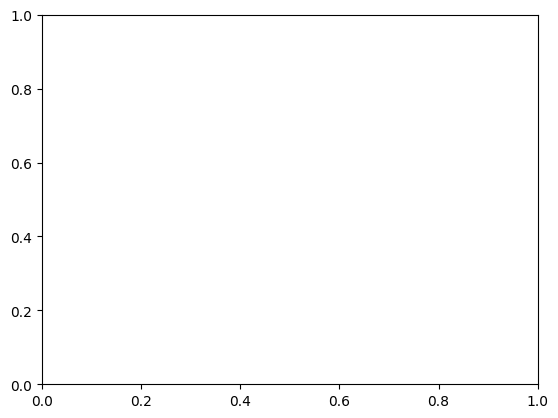

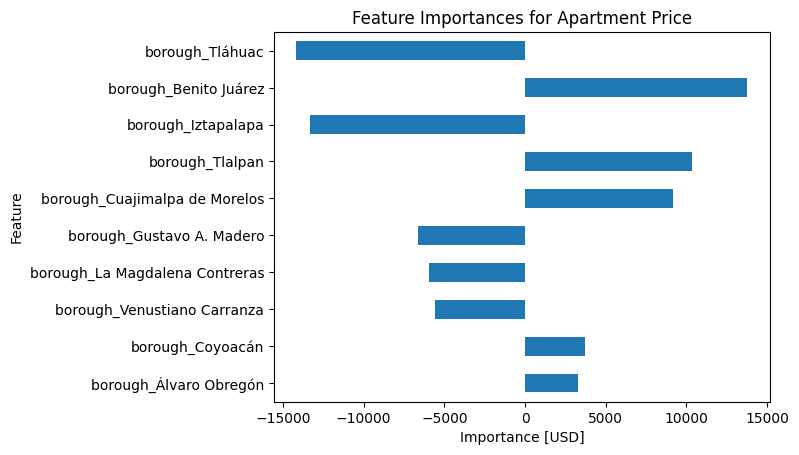

In [196]:
fig, ax = plt.subplots()

# Create the horizontal bar plot on the axes object
top_features = feat_imp.sort_values(key=abs).tail(10)
fig, ax = plt.subplots()
top_features.plot(kind="barh", ax=ax)


#  Label axes 
ax.set_xlabel("Importance [USD]") 
ax.set_ylabel("Feature")

# Add title 
ax.set_title("Feature Importances for Apartment Price")

---
Copyright 2024 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
